In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

## Load Dataset

In [2]:
X_train = np.loadtxt('TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
y_train = np.loadtxt('TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')

X_test = np.loadtxt('TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
y_test = np.loadtxt('TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')

print(X_train.shape)
print(X_test.shape)

(5000, 196)
(2500, 196)


## LDA

In [3]:
_, n_feature = X_train.shape

### Within Class Scatter

$$
\underline{\underline{S}}_{W} =\sum ^{c}_{k=1}\underline{\underline{S}}_{k} \ ,\ \underline{\underline{S}}_{k} =\sum _{\underline{x} \in D_{k}}(\underline{x} -\underline{\mu }_{k})(\underline{x} -\underline{\mu }_{k})^{T}
$$


In [4]:
S_W = np.zeros((n_feature, n_feature))
for i in range(10):
    X_i = X_train[y_train == i]
    m_i = np.mean(X_i, axis=0)
    S_i = (X_i - m_i).T @ (X_i - m_i)
    S_W += S_i

### Between Class Scatter

$$
\underline{\underline{S}}_{B} =\sum ^{c}_{k=1} N_{k}(\underline{\mu }_{k} -\underline{\mu })(\underline{\mu }_{k} -\underline{\mu })^{T}
$$


In [5]:
S_B = np.zeros((n_feature, n_feature))
m = np.mean(X_train, axis=0)
for i in range(10):
    X_i = X_train[y_train == i]
    n_i = X_i.shape[0]
    m_i = np.mean(X_i, axis=0)
    S_B += n_i * ((m_i - m).reshape(-1, 1) @ (m_i - m).T.reshape(1, -1))

### Separability Matrix

$$
\underline{\underline{S}}_{sep} =\left(\underline{\underline{S}}_{W} +\underbrace{\lambda I}_{regularization\ term}\right)^{-1}\underline{\underline{S}}_{B}
$$


In [6]:
S_sep = np.linalg.inv(S_W + (1e-9 * np.identity(n_feature))) @ S_B 

In [7]:
eigenvalues, eigenvectors = np.linalg.eig(S_sep)
print(eigenvectors)
print(eigenvalues)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.00319238 -0.03568961 -0.01526637 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]
[ 4.02535535e+00  3.24596427e+00  3.14309159e+00  1.65958838e+00
  1.48090011e+00  1.06686331e+00  8.04706026e-01  6.49131281e-01
  3.88372861e-01  5.58376911e-07 -5.59386766e-07 -4.60806335e-07
  4.19401361e-07 -4.19079294e-07  3.63622876e-07  3.19841784e-07
  2.87281450e-07 -3.16825965e-07  2.44781144e-07 -2.82430562e-07
 -2.69694223e-07 -2.41338789e-07 -2.23336348e-07  2.31299831e-07
 -2.02087718e-07 -1.83680097e-07 -1.74997487e-07 -1.75758426e-07
 -1.59742902e-07 -1.49646410e-07  2.14630783e-07  2.01229385e-07
  1.93179854e-07  1.75064029e-07  1.

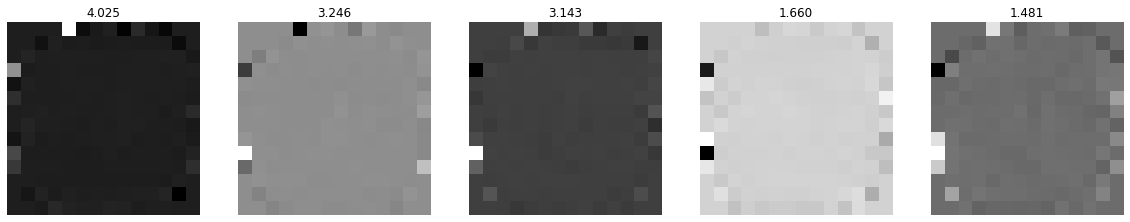

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i in range(5):
    axs[i].set_title('%0.3f'%eigenvalues[i])
    axs[i].imshow(eigenvectors[:, i].reshape(14, 14), cmap='gray')
    axs[i].axis('off')

## Find Optimal Linear Discriminants

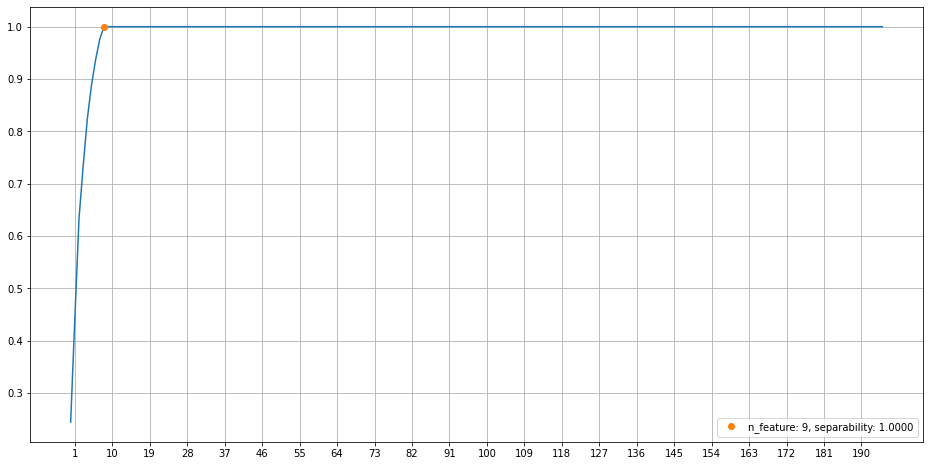

In [9]:
plt.figure(figsize=(16, 8))

sep = np.cumsum(eigenvalues)
sep = sep / np.max(sep)
plt.plot(sep)

idx = np.argmax(sep>0.99)
plt.plot(idx, sep[idx], 'o', label='n_feature: %d, separability: %0.4f' % (idx+1, sep[idx]))

plt.xticks(range(1, n_feature+1, 9))
plt.legend()
plt.grid()
plt.show()

optimal_ld = eigenvectors[:, :(idx+1)]

## Classification with Dimensionality Reduction

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [11]:
X_train_new = X_train @ optimal_ld
X_test_new = X_test @ optimal_ld

print(X_train_new.shape)
print(X_test_new.shape)

(5000, 9)
(2500, 9)


In [12]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_new, y_train)

y_predict = clf.predict(X_test_new)

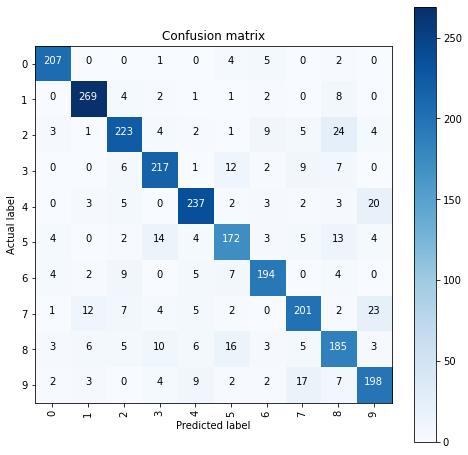

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, range(10))

In [14]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_test, y_predict)
print('Accuracy: %0.3f' % total_acc)

labels = list(set(y_test))
ccr = [cm[i, i] / cm[i, :].sum() for i in range(len(labels))]
for i, l in enumerate(labels):
    print('CCR-%s: %0.3f' % (l, ccr[i]))

Accuracy: 0.841
CCR-0: 0.945
CCR-1: 0.937
CCR-2: 0.808
CCR-3: 0.854
CCR-4: 0.862
CCR-5: 0.778
CCR-6: 0.862
CCR-7: 0.782
CCR-8: 0.764
CCR-9: 0.811
